In [21]:
import time
import random
import math
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datasets import load_dataset
import tiktoken

print('All imports done.')

All imports done.


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")



Using device: mps


In [23]:
# Data parameters
block_size = 128  # Sequence length for training
train_subset_size = 20000  # Number of samples to use from TinyStories
batch_size = 16

tinystories_weight = 0.5  # Proportion of TinyStories in mixed dataset (0.0 to skip)

In [24]:
# Load tokenizer
enc = tiktoken.get_encoding("gpt2")
vocab_size = enc.n_vocab

# Load TinyStories dataset
tinystories_seqs = []
if tinystories_weight > 0.0:
    print(f"Loading TinyStories from huggingface with weight={tinystories_weight}...")
    dataset = load_dataset("roneneldan/TinyStories", split="train")
    train_dataset = dataset.select(range(train_subset_size))
    for sample in train_dataset:
        text = sample['text']
        tokens = enc.encode(text)
        tokens = tokens[:block_size]
        if len(tokens) > 0:
            tinystories_seqs.append(tokens)
    print(f"TinyStories sequences: {len(tinystories_seqs)}")
else:
    print("TinyStories weight=0 => skipping TinyStories.")
other_seqs = []

Loading TinyStories from huggingface with weight=0.5...
TinyStories sequences: 20000
TinyStories sequences: 20000


In [25]:
class MixedSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, tinystories_seqs, other_seqs, p_tiny: float):
        super().__init__()
        self.tinystories_seqs = tinystories_seqs
        self.other_seqs = other_seqs
        self.p_tiny = p_tiny
        self.has_tinystories = (len(self.tinystories_seqs) > 0)
        self.has_other = (len(self.other_seqs) > 0)
        self.total_length = len(self.tinystories_seqs) + len(self.other_seqs)
        if self.total_length == 0:
            raise ValueError("No data found! Both TinyStories and other sets are empty.")

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        import random
        r = random.random()
        if self.has_tinystories and self.has_other:
            if r < self.p_tiny:
                i = random.randint(0, len(self.tinystories_seqs) - 1)
                seq = self.tinystories_seqs[i]
            else:
                i = random.randint(0, len(self.other_seqs) - 1)
                seq = self.other_seqs[i]
        elif self.has_tinystories:
            i = random.randint(0, len(self.tinystories_seqs) - 1)
            seq = self.tinystories_seqs[i]
        else:
            i = random.randint(0, len(self.other_seqs) - 1)
            seq = self.other_seqs[i]
        return torch.tensor(seq, dtype=torch.long)

In [26]:
def seq_collate_fn(batch):
    max_len = max(len(seq) for seq in batch)
    batch_size = len(batch)
    padded = torch.zeros(max_len, batch_size, dtype=torch.long)
    for i, seq in enumerate(batch):
        seq_len = seq.size(0)
        padded[:seq_len, i] = seq
    return padded

In [27]:
# Create dataset and loader
p_tiny = tinystories_weight
combined_dataset = MixedSequenceDataset(
    tinystories_seqs=tinystories_seqs,
    other_seqs=other_seqs,
    p_tiny=p_tiny
)

In [28]:
combined_dataset.total_length

20000

In [29]:
train_loader = torch.utils.data.DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=seq_collate_fn
)

print("DataLoader ready. Vocab size:", vocab_size)

DataLoader ready. Vocab size: 50257


In [30]:
### Validation 
# Validation data (next 2000 samples)
val_subset_size = train_subset_size // 10  # 2000
tinystories_val_seqs = []
print(f"Loading TinyStories val subset ({train_subset_size}:{train_subset_size + val_subset_size})...")
dataset_val = dataset.select(range(train_subset_size, train_subset_size + val_subset_size))  # 20000..21999
for sample in dataset_val:
    text = sample["text"]
    tokens = enc.encode(text)
    tokens = tokens[:block_size]
    if len(tokens) > 0:
        tinystories_val_seqs.append(tokens)
print(f"TinyStories VAL sequences: {len(tinystories_val_seqs)}")

# Create validation dataset and DataLoader

val_p_tiny = tinystories_weight  # same mixing proportion as training

val_dataset = MixedSequenceDataset(
    tinystories_seqs=tinystories_val_seqs,
    other_seqs=[],          # no other validation data for now
    p_tiny=val_p_tiny
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=seq_collate_fn
)

print("Validation DataLoader ready. Num val sequences:", len(val_dataset))

Loading TinyStories val subset (20000:22000)...
TinyStories VAL sequences: 2000
Validation DataLoader ready. Num val sequences: 2000


In [31]:
def compute_next_token_loss(logits, tokens_seq):
    '''
    logits: (seq_len, batch, vocab_size)
    tokens_seq: (seq_len, batch)
    Computes cross-entropy loss for next-token prediction.
    '''
    seq_len, batch = tokens_seq.shape
    # Predict next token: input t => predict t+1
    logits = logits[:-1]  # (seq_len-1, batch, vocab_size)
    targets = tokens_seq[1:]  # (seq_len-1, batch)
    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
    return loss

In [32]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization."""
    def __init__(self, dim: int, eps: float = 1e-6, bias: bool = True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.use_bias = bias
        self.bias = nn.Parameter(torch.zeros(dim)) if bias else None
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        y = (x / rms) * self.weight
        if self.use_bias:
            y = y + self.bias
        return y

In [33]:
class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention with optional KV cache."""
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)

    def _split_heads(self, t: torch.Tensor, T: int, B: int) -> torch.Tensor:
        return t.view(T, B, self.n_heads, self.head_dim).permute(1, 2, 0, 3)  # (B,H,T,D)

    def forward(self, x: torch.Tensor, past_kv=None):
        T, B, C = x.shape
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = self._split_heads(q, T, B)
        k = self._split_heads(k, T, B)
        v = self._split_heads(v, T, B)

        if past_kv is not None:
            k_cache, v_cache = past_kv
            if k_cache is not None:
                k = torch.cat([k_cache, k], dim=2)
                v = torch.cat([v_cache, v], dim=2)

        scale = 1.0 / math.sqrt(self.head_dim)
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B,H,T,T_total)
        if past_kv is None and T > 1:
            causal_mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
            attn_scores = attn_scores.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        attn_probs = torch.softmax(attn_scores, dim=-1)
        ctx = torch.matmul(attn_probs, v)  # (B,H,T,D)
        ctx = ctx.permute(2, 0, 1, 3).contiguous().view(T, B, C)
        out = self.o_proj(ctx)

        if past_kv is not None:
            return out, (k, v)
        else:
            return out


In [ ]:
class TransformerBlock(nn.Module):
   
    def __init__(self, d_model: int, n_heads: int, mlp_ratio: float = 4.0):
        super().__init__()
        self.attn_norm = RMSNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads)
        self.mlp_norm = RMSNorm(d_model)
        inner = int(mlp_ratio * d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, inner, bias=False),
            nn.SiLU(),
            nn.Linear(inner, d_model, bias=False),
        )

    def forward(self, x: torch.Tensor, past_kv=None):
        if past_kv is None:
            x = x + self.attn(self.attn_norm(x))
        else:
            attn_out, new_kv = self.attn(self.attn_norm(x), past_kv=past_kv)
            x = x + attn_out
        x = x + self.mlp(self.mlp_norm(x))
        if past_kv is not None:
            return x, new_kv
        return x


In [ ]:
class TransformerModel(nn.Module):
    
    def __init__(self,
                 vocab_size: int = 50257,
                 d_model: int = 512,
                 n_heads: int = 8,
                 n_blocks: int = 6,
                 max_seq_len: int = 2048,
                 mlp_ratio: float = 4.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_seq_len, d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, mlp_ratio) for _ in range(n_blocks)
        ])
        self.final_norm = RMSNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        
        self.lm_head.weight = self.token_embed.weight  # Weight tying

    def forward(self, tokens_seq: torch.Tensor, kv_cache=None):
        T, B = tokens_seq.shape
        if T > self.max_seq_len:
            tokens_seq = tokens_seq[-self.max_seq_len:]
            T = tokens_seq.shape[0]
        if kv_cache is not None and len(kv_cache) > 0 and kv_cache[0][0] is not None:
            cached_len = kv_cache[0][0].size(2)
        else:
            cached_len = 0
        pos = torch.arange(cached_len, cached_len + T, device=tokens_seq.device)
        x = self.token_embed(tokens_seq) + self.pos_embed(pos).unsqueeze(1)
        new_cache = [] if kv_cache is not None else None
        if kv_cache is None:
            for blk in self.blocks:
                x = blk(x)
        else:
            for blk, past in zip(self.blocks, kv_cache):
                x, updated = blk(x, past_kv=past)
                new_cache.append(updated)
        x = self.final_norm(x)
        #print(x.shape)
        logits = self.lm_head(x)
        if kv_cache is not None:
            return logits, new_cache
        return logits

In [36]:
def nucleus_sampling(logits, p=0.95):
    # Convert logits to probabilities
    prob_dist = torch.softmax(logits, dim=-1)

    # Sort probabilities in descending order and get indices
    sorted_probs, sorted_indices = torch.sort(prob_dist, descending=True)

    # Compute cumulative sum
    cumsum_probs = torch.cumsum(sorted_probs, dim=-1)

    # Find the cutoff index where cumulative probability exceeds p
    # We want to include all tokens up to where cumsum first exceeds p
    cutoff_mask = cumsum_probs <= p

    # Always include at least the first token (highest probability)
    # This handles edge case where first token alone has prob > p
    cutoff_mask[0] = True

    # Zero out probabilities beyond the nucleus
    filtered_probs = sorted_probs.clone()
    filtered_probs[~cutoff_mask] = 0.0

    # Renormalize the remaining probabilities
    filtered_probs = filtered_probs / filtered_probs.sum()

    # Sample from the filtered distribution
    sampled_index = torch.multinomial(filtered_probs, num_samples=1).item()

    # Map back to original token index
    chosen_token = sorted_indices[sampled_index].item()

    return chosen_token


In [37]:
def generate_text(model, enc, init_text, max_new_tokens=20, device="cpu",
                  top_p=None,
                  monosemantic_info=None,
                  do_monosemantic=False,
                  use_kv_cache=False):
    """
    A single code path for all models:
      - We keep a growing list 'context_tokens'.
      - At each step, we feed the entire context as (seq_len,1) to model(...).
      - We get model(...)->(seq_len,1,vocab_size). We take the final step's logits => logits[-1,0,:].
      - We pick next token (greedy or top-p), append to context_tokens.
      - Optionally do monosemantic analysis on that newly generated token.
    """
    was_training = model.training
    model.eval()
    with torch.no_grad():
        context_tokens = enc.encode(init_text)
        annotation_list = []

        kv_cache = None
        # Prime KV cache step-by-step over the initial prompt for strict causality
        if use_kv_cache and hasattr(model, 'blocks') and len(context_tokens) > 0:
            kv_cache = [(None, None) for _ in range(len(model.blocks))]
            for tid in context_tokens:
                tok = torch.tensor([tid], dtype=torch.long, device=device).unsqueeze(1)  # (1,1)
                _, kv_cache = model(tok, kv_cache=kv_cache)

        for step_i in range(max_new_tokens):
            if use_kv_cache and hasattr(model, 'blocks'):
                # Use only the last token and advance cache
                if len(context_tokens) == 0:
                    # Fallback: no context, create a space token as a starter
                    last_id = enc.encode(" ")[-1]
                else:
                    last_id = context_tokens[-1]
                last_token = torch.tensor([last_id], dtype=torch.long, device=device).unsqueeze(1)  # (1,1)
                logits_seq, kv_cache = model(last_token, kv_cache=kv_cache if kv_cache is not None else [(None, None) for _ in range(len(model.blocks))])
                next_logits = logits_seq[-1, 0, :]
            else:
                # Fallback: full context each step (works for all models)
                seq_tensor = torch.tensor(context_tokens, dtype=torch.long, device=device).unsqueeze(1)
                logits_seq = model(seq_tensor)              # (seq_len,1,vocab_size)
                next_logits = logits_seq[-1, 0, :]         # shape (vocab_size,)

            if top_p is None:
                # greedy
                chosen_token = torch.argmax(next_logits).item()
            else:
                chosen_token = nucleus_sampling(next_logits, p=top_p)

            context_tokens.append(chosen_token)

            if do_monosemantic and monosemantic_info is not None:
                neighbors = monosemantic_analysis_for_token(
                    chosen_token, model, monosemantic_info, enc, device=device, top_n=5
                )
                annotation_list.append((chosen_token, neighbors))
            else:
                annotation_list.append((chosen_token, []))

    model.train(was_training)

    final_text = enc.decode(context_tokens)
    prefix_text = enc.decode(context_tokens[:-max_new_tokens])
    annotated_strs = [prefix_text]
    for (tid, neighs) in annotation_list:
        token_str = enc.decode([tid])
        if neighs:
            neighbor_strs = [f"{enc.decode([x[1]])}" for x in neighs]
            annotated = f"{token_str}[NN={neighbor_strs}]"
        else:
            annotated = token_str
        annotated_strs.append(annotated)

    annotated_text = "".join(annotated_strs)
    return final_text, annotated_text


In [38]:
def train_one_model(model,
                    loader,
                    epochs,
                    model_name,
                    device,
                    lr=1e-3,
                    log_steps=100,
                    sample_interval=30,
                    max_steps_per_epoch=None,
                    enc=None,
                    monosemantic_info=None,
                    prompt="Once upon a",
                    log_csv_path: str = "",
                    log_flush_steps: int = 100,
                    val_loader=None,
                    val_log_csv_path: str = "",
                    val_interval_steps: int = None):
    """
    Train the model and optionally run/record validation aligned to training global_step.

    If val_loader and val_log_csv_path are provided, a validation pass is run
    every `val_interval_steps` training steps (or once per epoch if
    val_interval_steps is None). Validation loss is logged with the same
    schema as training: timestamp,model,epoch,step_in_epoch,global_step,loss
    and model name "Transformer_val".
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Buffered training logging setup
    loss_buffer = []
    csv_file = None
    if log_csv_path:
        log_dir = os.path.dirname(log_csv_path)
        if log_dir:
            os.makedirs(log_dir, exist_ok=True)
        file_exists = os.path.exists(log_csv_path)
        csv_file = open(log_csv_path, 'a', newline='')
        # Write header if empty
        if not file_exists or os.path.getsize(log_csv_path) == 0:
            csv_file.write('timestamp,model,epoch,step_in_epoch,global_step,loss\n')

    # Validation logging setup (separate CSV)
    val_csv_file = None
    if val_loader is not None and val_log_csv_path:
        val_log_dir = os.path.dirname(val_log_csv_path)
        if val_log_dir:
            os.makedirs(val_log_dir, exist_ok=True)
        val_file_exists = os.path.exists(val_log_csv_path)
        val_csv_file = open(val_log_csv_path, 'a', newline='')
        if not val_file_exists or os.path.getsize(val_log_csv_path) == 0:
            val_csv_file.write('timestamp,model,epoch,step_in_epoch,global_step,loss\n')

    start_time = time.time()
    next_sample_time = start_time
    global_step = 0

    def run_validation(current_epoch, current_global_step):
        """Run one full validation pass and log a single avg-loss point."""
        if val_loader is None or val_csv_file is None:
            return
        model.eval()
        val_losses = []
        with torch.no_grad():
            for _, batch_tokens in enumerate(val_loader, start=1):
                batch_tokens = batch_tokens.to(device)
                logits = model(batch_tokens)
                vloss = compute_next_token_loss(logits, batch_tokens)
                val_losses.append(vloss.item())
        if not val_losses:
            return
        avg_val_loss = float(sum(val_losses) / len(val_losses))
        print(f"[Validation] Epoch {current_epoch}, global_step {current_global_step}, avg loss: {avg_val_loss:.4f}")
        # Log as one row aligned with training global_step
        val_csv_file.write(
            f"{time.time()},Transformer_val,{current_epoch},1,{current_global_step},{avg_val_loss}\n"
        )
        val_csv_file.flush()
        model.train()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        partial_loss = 0.0
        partial_count = 0

        step_in_epoch = 0
        for batch_idx, batch_tokens in enumerate(loader, start=1):
            step_in_epoch += 1
            global_step += 1

            batch_tokens = batch_tokens.to(device)  # (seq_len, batch)

            logits = model(batch_tokens)  # (seq_len, batch, vocab_size)
            loss = compute_next_token_loss(logits, batch_tokens)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            partial_loss += loss.item()
            partial_count += 1

            # Buffer this step's loss
            if csv_file is not None:
                loss_buffer.append(f"{time.time()},{model_name},{epoch},{step_in_epoch},{global_step},{loss.item()}\n")
                if len(loss_buffer) >= log_flush_steps:
                    csv_file.writelines(loss_buffer)
                    csv_file.flush()
                    loss_buffer.clear()

            # Periodic training progress print
            if batch_idx % log_steps == 0:
                avg_part_loss = partial_loss / partial_count
                print(f"[{model_name}] Epoch {epoch}/{epochs}, "
                      f"Step {batch_idx}/{len(loader)} (global step: {global_step}) "
                      f"Partial Avg Loss: {avg_part_loss:.4f}")
                partial_loss = 0.0
                partial_count = 0

            # Periodic text sampling
            current_time = time.time()
            if current_time >= next_sample_time and enc is not None:
                with torch.no_grad():
                    print(f"\n[{model_name}] Generating sample text (greedy) at epoch={epoch}, step={batch_idx}...")
                    text_greedy, ann_greedy = generate_text(
                        model, enc, prompt, max_new_tokens=20, device=device,
                        top_p=None,
                        use_kv_cache=False,
                        monosemantic_info=monosemantic_info,
                        do_monosemantic=(monosemantic_info is not None)
                    )
                    print(f" Greedy Sample: {text_greedy}")
                    print(f" Annotated: {ann_greedy}\n")

                    print(f"[{model_name}] Generating sample text (top-p=0.95) at epoch={epoch}, step={batch_idx}...")
                    text_topp, ann_topp = generate_text(
                        model, enc, prompt, max_new_tokens=20, device=device,
                        top_p=0.95,
                        use_kv_cache=False,
                        monosemantic_info=monosemantic_info,
                        do_monosemantic=(monosemantic_info is not None)
                    )
                    print(f" Top-p (p=0.95) Sample: {text_topp}")
                    print(f" Annotated: {ann_topp}\n")

                    print(f"[{model_name}] Generating sample text (top-p=1.0) at epoch={epoch}, step={batch_idx}...")
                    text_topp1, ann_topp1 = generate_text(
                        model, enc, prompt, max_new_tokens=20, device=device,
                        top_p=1.0,
                        use_kv_cache=False,
                        monosemantic_info=monosemantic_info,
                        do_monosemantic=(monosemantic_info is not None)
                    )
                    print(f" Top-p (p=1.0) Sample: {text_topp1}")
                    print(f" Annotated: {ann_topp1}\n")

                next_sample_time = current_time + sample_interval

            # Run validation either every N steps or once per epoch if val_interval_steps is None
            if val_loader is not None and val_log_csv_path:
                if val_interval_steps is not None:
                    if global_step % val_interval_steps == 0:
                        run_validation(epoch, global_step)
                else:
                    # If no interval specified, run once at the last batch of the epoch
                    if max_steps_per_epoch is None:
                        is_last_batch = (batch_idx == len(loader))
                    else:
                        is_last_batch = (step_in_epoch >= max_steps_per_epoch or batch_idx == len(loader))
                    if is_last_batch:
                        run_validation(epoch, global_step)

            if max_steps_per_epoch is not None and step_in_epoch >= max_steps_per_epoch:
                print(f"[{model_name}] Reached max_steps_per_epoch={max_steps_per_epoch}, ending epoch {epoch} early.")
                break

        avg_loss = total_loss / step_in_epoch
        print(f"[{model_name}] *** End of Epoch {epoch} *** Avg Loss: {avg_loss:.4f}")

    # Final flush for training log
    if csv_file is not None:
        if loss_buffer:
            csv_file.writelines(loss_buffer)
            csv_file.flush()
        csv_file.close()

    # Close validation log if open
    if val_csv_file is not None:
        val_csv_file.close()

In [39]:
# Training parameters
epochs = 5
learning_rate = 1e-3
log_steps = 100
sample_interval = 30  # seconds between text samples during training
max_steps_per_epoch = 1000  # Limit to 1000 steps per epoch for faster training

# Prompt for text generation
default_prompt = "Once upon a time"

## Train Three Models with Different Epochs

Train three separate models:
- Model 1: 2 epochs
- Model 2: 5 epochs  
- Model 3: 8 epochs

In [40]:
# Model 1: 2 epochs
print("=" * 60)
print("TRAINING MODEL 1: 2 EPOCHS")
print("=" * 60)
model_2epochs = TransformerModel(vocab_size=vocab_size, d_model=128, n_heads=4, n_blocks=2, max_seq_len=block_size).to(device)

train_one_model(
    model=model_2epochs,
    loader=train_loader,
    epochs=2,
    model_name="Transformer_2epochs",
    device=device,
    lr=learning_rate,
    log_steps=log_steps,
    sample_interval=sample_interval,
    max_steps_per_epoch=max_steps_per_epoch,
    enc=enc,
    prompt=default_prompt,
    log_csv_path="training_logs/hyperparam_exp/model_2epochs_train.csv",
    val_loader=val_loader,
    val_log_csv_path="hyperparam_exp/model_2epochs_val.csv",
    val_interval_steps=log_steps
)

print("\n✓ Model 1 (2 epochs) training complete!\n")

TRAINING MODEL 1: 2 EPOCHS

[Transformer_2epochs] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_2epochs] Generating sample text (top-p=0.95) at epoch=1, step=1...

[Transformer_2epochs] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_2epochs] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Top-p (p=0.95) Sample: Once upon a time time time time time time time time time time time time time time time time time time time ti

In [41]:
# Model 2: 5 epochs
print("=" * 60)
print("TRAINING MODEL 2: 5 EPOCHS")
print("=" * 60)
model_5epochs = TransformerModel(vocab_size=vocab_size, d_model=128, n_heads=4, n_blocks=2, max_seq_len=block_size).to(device)

train_one_model(
    model=model_5epochs,
    loader=train_loader,
    epochs=5,
    model_name="Transformer_5epochs",
    device=device,
    lr=learning_rate,
    log_steps=log_steps,
    sample_interval=sample_interval,
    max_steps_per_epoch=max_steps_per_epoch,
    enc=enc,
    prompt=default_prompt,
    log_csv_path="training_logs/hyperparam_exp/model_5epochs_train.csv",
    val_loader=val_loader,
    val_log_csv_path="training_logs/hyperparam_exp/model_5epochs_val.csv",
    val_interval_steps=log_steps
)

print("\n✓ Model 2 (5 epochs) training complete!\n")

TRAINING MODEL 2: 5 EPOCHS

[Transformer_5epochs] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_5epochs] Generating sample text (top-p=0.95) at epoch=1, step=1...

[Transformer_5epochs] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_5epochs] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Top-p (p=0.95) Sample: Once upon a time time time time time time time time time time time time time time time time time time time ti

In [42]:
# Model 3: 8 epochs
print("=" * 60)
print("TRAINING MODEL 3: 8 EPOCHS")
print("=" * 60)
model_8epochs = TransformerModel(vocab_size=vocab_size, d_model=128, n_heads=4, n_blocks=2, max_seq_len=block_size).to(device)

train_one_model(
    model=model_8epochs,
    loader=train_loader,
    epochs=8,
    model_name="Transformer_8epochs",
    device=device,
    lr=learning_rate,
    log_steps=log_steps,
    sample_interval=sample_interval,
    max_steps_per_epoch=max_steps_per_epoch,
    enc=enc,
    prompt=default_prompt,
    log_csv_path="training_logs/hyperparam_exp/model_8epochs_train.csv",
    val_loader=val_loader,
    val_log_csv_path="training_logs/hyperparam_exp/model_8epochs_val.csv",
    val_interval_steps=log_steps
)

print("\n✓ Model 3 (8 epochs) training complete!\n")

TRAINING MODEL 3: 8 EPOCHS

[Transformer_8epochs] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_8epochs] Generating sample text (top-p=0.95) at epoch=1, step=1...

[Transformer_8epochs] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_8epochs] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Top-p (p=0.95) Sample: Once upon a time time time time time time time time time time time time time time time time time time time ti

## Train Three More Models with Different Learning Rates

Train three additional models with varying learning rates (keeping epochs fixed at 3 for faster training):
- Model 4: lr = 5e-4 (lower learning rate)
- Model 5: lr = 1e-3 (baseline)
- Model 6: lr = 5e-3 (higher learning rate)

In [43]:
# Model 4: lr = 5e-4 (lower learning rate)
print("=" * 60)
print("TRAINING MODEL 4: lr=5e-4")
print("=" * 60)
model_lr5e4 = TransformerModel(vocab_size=vocab_size, d_model=96, n_heads=4, n_blocks=2, max_seq_len=block_size).to(device)

train_one_model(
    model=model_lr5e4,
    loader=train_loader,
    epochs=3,
    model_name="Transformer_lr5e4",
    device=device,
    lr=5e-4,
    log_steps=log_steps,
    sample_interval=sample_interval,
    max_steps_per_epoch=max_steps_per_epoch,
    enc=enc,
    prompt=default_prompt,
    log_csv_path="training_logs/hyperparam_exp/model_lr5e4_train.csv",
    val_loader=val_loader,
    val_log_csv_path="training_logs/hyperparam_exp/model_lr5e4_val.csv",
    val_interval_steps=log_steps
)

print("\n✓ Model 4 (lr=5e-4) training complete!\n")

TRAINING MODEL 4: lr=5e-4

[Transformer_lr5e4] Generating sample text (greedy) at epoch=1, step=1...

[Transformer_lr5e4] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_lr5e4] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Top-p (p=0.95) Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_lr5e4] Generating sample text (top-p=1.0) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 A

In [44]:
# Model 5: lr = 1e-3 (baseline)
print("=" * 60)
print("TRAINING MODEL 5: lr=1e-3")
print("=" * 60)
model_lr1e3 = TransformerModel(vocab_size=vocab_size, d_model=96, n_heads=4, n_blocks=2, max_seq_len=block_size).to(device)

train_one_model(
    model=model_lr1e3,
    loader=train_loader,
    epochs=3,
    model_name="Transformer_lr1e3",
    device=device,
    lr=1e-3,
    log_steps=log_steps,
    sample_interval=sample_interval,
    max_steps_per_epoch=max_steps_per_epoch,
    enc=enc,
    prompt=default_prompt,
    log_csv_path="training_logs/hyperparam_exp/model_lr1e3_train.csv",
    val_loader=val_loader,
    val_log_csv_path="training_logs/hyperparam_exp/model_lr1e3_val.csv",
    val_interval_steps=log_steps
)

print("\n✓ Model 5 (lr=1e-3) training complete!\n")

TRAINING MODEL 5: lr=1e-3

[Transformer_lr1e3] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_lr1e3] Generating sample text (top-p=0.95) at epoch=1, step=1...

[Transformer_lr1e3] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_lr1e3] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Top-p (p=0.95) Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 

In [45]:
# Model 6: lr = 5e-3 (higher learning rate)
print("=" * 60)
print("TRAINING MODEL 6: lr=5e-3")
print("=" * 60)
model_lr5e3 = TransformerModel(vocab_size=vocab_size, d_model=96, n_heads=4, n_blocks=2, max_seq_len=block_size).to(device)

train_one_model(
    model=model_lr5e3,
    loader=train_loader,
    epochs=3,
    model_name="Transformer_lr5e3",
    device=device,
    lr=5e-3,
    log_steps=log_steps,
    sample_interval=sample_interval,
    max_steps_per_epoch=max_steps_per_epoch,
    enc=enc,
    prompt=default_prompt,
    log_csv_path="training_logs/hyperparam_exp/model_lr5e3_train.csv",
    val_loader=val_loader,
    val_log_csv_path="training_logs/hyperparam_exp/model_lr5e3_val.csv",
    val_interval_steps=log_steps
)

print("\n✓ Model 6 (lr=5e-3) training complete!\n")

TRAINING MODEL 6: lr=5e-3

[Transformer_lr5e3] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_lr5e3] Generating sample text (top-p=0.95) at epoch=1, step=1...

[Transformer_lr5e3] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 Annotated: Once upon a time time time time time time time time time time time time time time time time time time time time time

[Transformer_lr5e3] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Top-p (p=0.95) Sample: Once upon a time time time time time time time time time time time time time time time time time time time time time
 

 will ## Save All Six Models

In [46]:
# Create directory for saved models
save_dir = "hyperparam_models/hyperparam_exp"
os.makedirs(save_dir, exist_ok=True)

# Save Model 1 (2 epochs)
torch.save(model_2epochs.state_dict(), os.path.join(save_dir, "model_2epochs.pt"))
with open(os.path.join(save_dir, "model_2epochs_meta.json"), 'w') as f:
    json.dump({"epochs": 2, "d_model": 128, "n_heads": 4, "n_blocks": 2, "vocab_size": vocab_size}, f, indent=2)
print("✓ Model 1 (2 epochs) saved")

# Save Model 2 (5 epochs)
torch.save(model_5epochs.state_dict(), os.path.join(save_dir, "model_5epochs.pt"))
with open(os.path.join(save_dir, "model_5epochs_meta.json"), 'w') as f:
    json.dump({"epochs": 5, "d_model": 128, "n_heads": 4, "n_blocks": 2, "vocab_size": vocab_size}, f, indent=2)
print("✓ Model 2 (5 epochs) saved")

# Save Model 3 (8 epochs)
torch.save(model_8epochs.state_dict(), os.path.join(save_dir, "model_8epochs.pt"))
with open(os.path.join(save_dir, "model_8epochs_meta.json"), 'w') as f:
    json.dump({"epochs": 8, "d_model": 128, "n_heads": 4, "n_blocks": 2, "vocab_size": vocab_size}, f, indent=2)
print("✓ Model 3 (8 epochs) saved")

# Save Model 4 (lr=5e-4)
torch.save(model_lr5e4.state_dict(), os.path.join(save_dir, "model_lr5e4.pt"))
with open(os.path.join(save_dir, "model_lr5e4_meta.json"), 'w') as f:
    json.dump({"lr": 5e-4, "epochs": 3, "d_model": 96, "n_heads": 4, "n_blocks": 2, "vocab_size": vocab_size}, f, indent=2)
print("✓ Model 4 (lr=5e-4) saved")

# Save Model 5 (lr=1e-3)
torch.save(model_lr1e3.state_dict(), os.path.join(save_dir, "model_lr1e3.pt"))
with open(os.path.join(save_dir, "model_lr1e3_meta.json"), 'w') as f:
    json.dump({"lr": 1e-3, "epochs": 3, "d_model": 96, "n_heads": 4, "n_blocks": 2, "vocab_size": vocab_size}, f, indent=2)
print("✓ Model 5 (lr=1e-3) saved")

# Save Model 6 (lr=5e-3)
torch.save(model_lr5e3.state_dict(), os.path.join(save_dir, "model_lr5e3.pt"))
with open(os.path.join(save_dir, "model_lr5e3_meta.json"), 'w') as f:
    json.dump({"lr": 5e-3, "epochs": 3, "d_model": 96, "n_heads": 4, "n_blocks": 2, "vocab_size": vocab_size}, f, indent=2)
print("✓ Model 6 (lr=5e-3) saved")

print(f"\nAll 6 models saved to: {save_dir}")

✓ Model 1 (2 epochs) saved
✓ Model 2 (5 epochs) saved
✓ Model 2 (5 epochs) saved
✓ Model 3 (8 epochs) saved
✓ Model 3 (8 epochs) saved
✓ Model 4 (lr=5e-4) saved
✓ Model 5 (lr=1e-3) saved
✓ Model 6 (lr=5e-3) saved

All 6 models saved to: hyperparam_models/hyperparam_exp
✓ Model 4 (lr=5e-4) saved
✓ Model 5 (lr=1e-3) saved
✓ Model 6 (lr=5e-3) saved

All 6 models saved to: hyperparam_models/hyperparam_exp


## Compare Training Curves

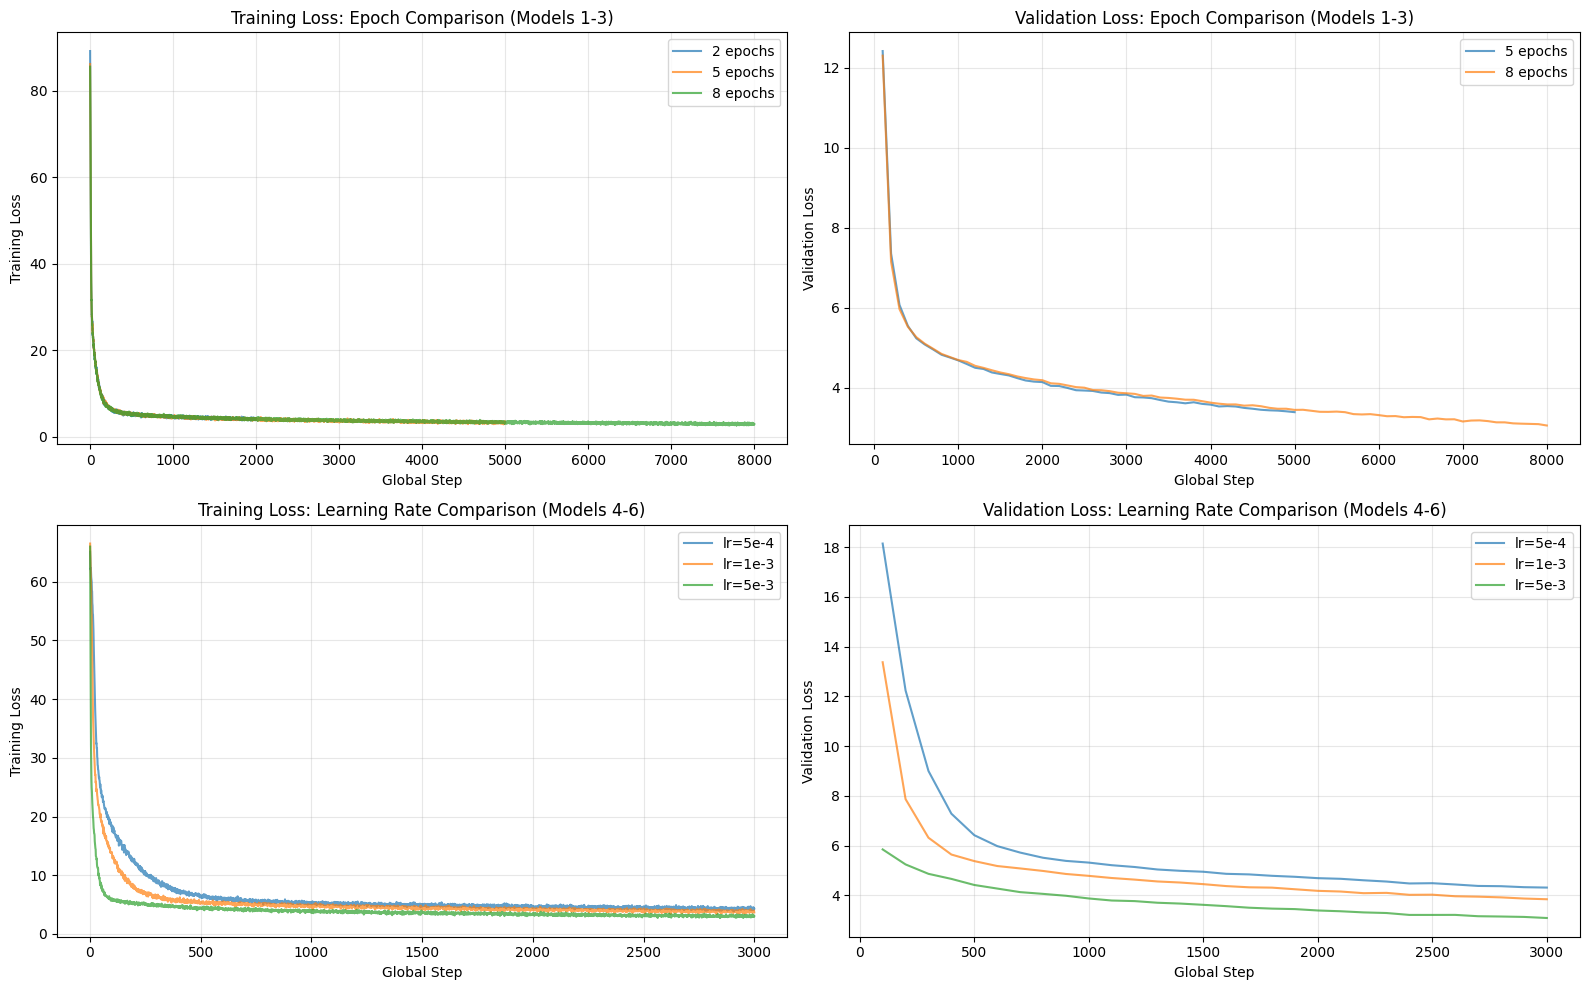


FINAL LOSS SUMMARY

Epoch Comparison (Models 1-3):
  2 epochs - Train: 4.3007, Val: N/A
  5 epochs - Train: 3.3711, Val: 3.3893
  8 epochs - Train: 2.9413, Val: 3.0556

Learning Rate Comparison (Models 4-6, 3 epochs each):
  lr=5e-4  - Train: 4.3161, Val: 4.3159
  lr=1e-3  - Train: 3.6834, Val: 3.8469
  lr=5e-3  - Train: 3.0019, Val: 3.0931


In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Load training logs
def load_log(path):
    if not os.path.exists(path):
        return None, None
    data = np.genfromtxt(path, delimiter=",", skip_header=1)
    return data[:, 4], data[:, 5]  # global_step, loss

# Load epoch comparison (Models 1-3)
m2_train_steps, m2_train_loss = load_log("training_logs/hyperparam_exp/model_2epochs_train.csv")
m2_val_steps, m2_val_loss = load_log("training_logs/hyperparam_exp/model_2epochs_val.csv")

m5_train_steps, m5_train_loss = load_log("training_logs/hyperparam_exp/model_5epochs_train.csv")
m5_val_steps, m5_val_loss = load_log("training_logs/hyperparam_exp/model_5epochs_val.csv")

m8_train_steps, m8_train_loss = load_log("training_logs/hyperparam_exp/model_8epochs_train.csv")
m8_val_steps, m8_val_loss = load_log("training_logs/hyperparam_exp/model_8epochs_val.csv")

# Load learning rate comparison (Models 4-6)
m4_train_steps, m4_train_loss = load_log("training_logs/hyperparam_exp/model_lr5e4_train.csv")
m4_val_steps, m4_val_loss = load_log("training_logs/hyperparam_exp/model_lr5e4_val.csv")

m5lr_train_steps, m5lr_train_loss = load_log("training_logs/hyperparam_exp/model_lr1e3_train.csv")
m5lr_val_steps, m5lr_val_loss = load_log("training_logs/hyperparam_exp/model_lr1e3_val.csv")

m6_train_steps, m6_train_loss = load_log("training_logs/hyperparam_exp/model_lr5e3_train.csv")
m6_val_steps, m6_val_loss = load_log("training_logs/hyperparam_exp/model_lr5e3_val.csv")

# Plot training curves - 2 rows x 2 cols
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Row 1: Epoch comparison (Models 1-3)
# Training loss
if m2_train_steps is not None:
    axes[0, 0].plot(m2_train_steps, m2_train_loss, label="2 epochs", alpha=0.7, linewidth=1.5)
if m5_train_steps is not None:
    axes[0, 0].plot(m5_train_steps, m5_train_loss, label="5 epochs", alpha=0.7, linewidth=1.5)
if m8_train_steps is not None:
    axes[0, 0].plot(m8_train_steps, m8_train_loss, label="8 epochs", alpha=0.7, linewidth=1.5)

axes[0, 0].set_xlabel("Global Step")
axes[0, 0].set_ylabel("Training Loss")
axes[0, 0].set_title("Training Loss: Epoch Comparison (Models 1-3)")
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# Validation loss
if m2_val_steps is not None:
    axes[0, 1].plot(m2_val_steps, m2_val_loss, label="2 epochs", alpha=0.7, linewidth=1.5)
if m5_val_steps is not None:
    axes[0, 1].plot(m5_val_steps, m5_val_loss, label="5 epochs", alpha=0.7, linewidth=1.5)
if m8_val_steps is not None:
    axes[0, 1].plot(m8_val_steps, m8_val_loss, label="8 epochs", alpha=0.7, linewidth=1.5)

axes[0, 1].set_xlabel("Global Step")
axes[0, 1].set_ylabel("Validation Loss")
axes[0, 1].set_title("Validation Loss: Epoch Comparison (Models 1-3)")
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# Row 2: Learning rate comparison (Models 4-6)
# Training loss
if m4_train_steps is not None:
    axes[1, 0].plot(m4_train_steps, m4_train_loss, label="lr=5e-4", alpha=0.7, linewidth=1.5)
if m5lr_train_steps is not None:
    axes[1, 0].plot(m5lr_train_steps, m5lr_train_loss, label="lr=1e-3", alpha=0.7, linewidth=1.5)
if m6_train_steps is not None:
    axes[1, 0].plot(m6_train_steps, m6_train_loss, label="lr=5e-3", alpha=0.7, linewidth=1.5)

axes[1, 0].set_xlabel("Global Step")
axes[1, 0].set_ylabel("Training Loss")
axes[1, 0].set_title("Training Loss: Learning Rate Comparison (Models 4-6)")
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# Validation loss
if m4_val_steps is not None:
    axes[1, 1].plot(m4_val_steps, m4_val_loss, label="lr=5e-4", alpha=0.7, linewidth=1.5)
if m5lr_val_steps is not None:
    axes[1, 1].plot(m5lr_val_steps, m5lr_val_loss, label="lr=1e-3", alpha=0.7, linewidth=1.5)
if m6_val_steps is not None:
    axes[1, 1].plot(m6_val_steps, m6_val_loss, label="lr=5e-3", alpha=0.7, linewidth=1.5)

axes[1, 1].set_xlabel("Global Step")
axes[1, 1].set_ylabel("Validation Loss")
axes[1, 1].set_title("Validation Loss: Learning Rate Comparison (Models 4-6)")
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("FINAL LOSS SUMMARY")
print("="*60)
print("\nEpoch Comparison (Models 1-3):")
if m2_train_loss is not None:
    val_str = f"{m2_val_loss[-1]:.4f}" if m2_val_loss is not None else "N/A"
    print(f"  2 epochs - Train: {m2_train_loss[-1]:.4f}, Val: {val_str}")
if m5_train_loss is not None:
    val_str = f"{m5_val_loss[-1]:.4f}" if m5_val_loss is not None else "N/A"
    print(f"  5 epochs - Train: {m5_train_loss[-1]:.4f}, Val: {val_str}")
if m8_train_loss is not None:
    val_str = f"{m8_val_loss[-1]:.4f}" if m8_val_loss is not None else "N/A"
    print(f"  8 epochs - Train: {m8_train_loss[-1]:.4f}, Val: {val_str}")

print("\nLearning Rate Comparison (Models 4-6, 3 epochs each):")
if m4_train_loss is not None:
    val_str = f"{m4_val_loss[-1]:.4f}" if m4_val_loss is not None else "N/A"
    print(f"  lr=5e-4  - Train: {m4_train_loss[-1]:.4f}, Val: {val_str}")
if m5lr_train_loss is not None:
    val_str = f"{m5lr_val_loss[-1]:.4f}" if m5lr_val_loss is not None else "N/A"
    print(f"  lr=1e-3  - Train: {m5lr_train_loss[-1]:.4f}, Val: {val_str}")
if m6_train_loss is not None:
    val_str = f"{m6_val_loss[-1]:.4f}" if m6_val_loss is not None else "N/A"
    print(f"  lr=5e-3  - Train: {m6_train_loss[-1]:.4f}, Val: {val_str}")

## Load a Saved Model

To load the model later for inference or continued training:

In [50]:
# Load all six saved models (if present) and generate sample text from each

model_infos = [
    ("model_2epochs",  {"d_model": 128, "n_heads": 4, "n_blocks": 2, "epochs": 2}),
    ("model_5epochs",  {"d_model": 128, "n_heads": 4, "n_blocks": 2, "epochs": 5}),
    ("model_8epochs",  {"d_model": 128, "n_heads": 4, "n_blocks": 2, "epochs": 8}),
    ("model_lr5e4",    {"d_model": 96,  "n_heads": 4, "n_blocks": 2, "epochs": 3, "lr": 5e-4}),
    ("model_lr1e3",    {"d_model": 96,  "n_heads": 4, "n_blocks": 2, "epochs": 3, "lr": 1e-3}),
    ("model_lr5e3",    {"d_model": 96,  "n_heads": 4, "n_blocks": 2, "epochs": 3, "lr": 5e-3}),
]

saved_dir = "hyperparam_models/hyperparam_exp"
max_new_tokens = 50
prompt = default_prompt

for name, cfg in model_infos:
    ckpt_path = os.path.join(saved_dir, f"{name}.pt")
    if not os.path.exists(ckpt_path):
        print(f"✗ Checkpoint not found for {name}: {ckpt_path}")
        continue

    print("\n" + "=" * 80)
    print(f"LOADING {name} from {ckpt_path}")
    print("=" * 80)

    # Recreate architecture to match training
    model = TransformerModel(
        vocab_size=vocab_size,
        d_model=cfg["d_model"],
        n_heads=cfg["n_heads"],
        n_blocks=cfg["n_blocks"],
        max_seq_len=block_size,
    ).to(device)

    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)

    # Generate greedy, top-p=0.95, and top-p=1.0 samples
    with torch.no_grad():
        text_greedy, _ = generate_text(
            model, enc, prompt,
            max_new_tokens=max_new_tokens,
            device=device,
            top_p=None,
            use_kv_cache=False,
            monosemantic_info=None,
            do_monosemantic=False,
        )
        text_topp, _ = generate_text(
            model, enc, prompt,
            max_new_tokens=max_new_tokens,
            device=device,
            top_p=0.95,
            use_kv_cache=False,
            monosemantic_info=None,
            do_monosemantic=False,
        )
        text_topp1, _ = generate_text(
            model, enc, prompt,
            max_new_tokens=max_new_tokens,
            device=device,
            top_p=1.0,
            use_kv_cache=False,
            monosemantic_info=None,
            do_monosemantic=False,
        )

    print(f"\n[{name}] Greedy generation:\n{text_greedy}\n")
    print(f"[{name}] Top-p (0.95) generation:\n{text_topp}\n")
    print(f"[{name}] Top-p (1.0) generation:\n{text_topp1}\n")


LOADING model_2epochs from hyperparam_models/hyperparam_exp/model_2epochs.pt

[model_2epochs] Greedy generation:
Once upon a time, there was a little girl named Lily. She loved to play with her toys and her mommy. One day, Lily's mommy was very happy to play with her mommy. She was very happy and her mommy, but she saw

[model_2epochs] Top-p (0.95) generation:
Once upon a time, in a little bear. He lived in a grass, she pointed mouse! bear and make his want he decided to line most next day and fly plants went to forgotten some rabbit. He explored and through it inside.

His mom said there

[model_2epochs] Top-p (1.0) generation:
Once upon a time there was two girl named Lily. She had aSoon bright said she night and Do watch home and fire. One day, "It is me enough around around and threw. The time to eat it. She put the remember below was lizard that one


LOADING model_5epochs from hyperparam_models/hyperparam_exp/model_5epochs.pt

[model_2epochs] Greedy generation:
Once upon a time,